In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer

2023-05-25 19:22:44.190356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset

In [63]:
dataset = pd.read_csv('dataset.csv')
#dataset.drop(dataset[dataset['value'].isna()].index, inplace = True)

# Train Custom Tokenizer for Sentence Modeling

In [3]:
def batch_iterator(batch_size=1000, size=len(dataset)):
    progress_bar = tqdm(range(0, size, batch_size))
    df = dataset
    for x in range(0, size, batch_size):
        yield df['value'].to_list()
        progress_bar.update(1)

In [4]:
training_corpus = batch_iterator()

In [5]:
old_tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

In [6]:
tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, 32000)

  0%|          | 0/471 [00:00<?, ?it/s]

In [7]:
tokenizer.save_pretrained("RadCLIP")

('RadCLIP/tokenizer_config.json',
 'RadCLIP/special_tokens_map.json',
 'RadCLIP/vocab.txt',
 'RadCLIP/added_tokens.json',
 'RadCLIP/tokenizer.json')

In [68]:
tokenizer = AutoTokenizer.from_pretrained('RadCLIP')

loading file vocab.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


# Create Tokenizer

In [69]:
print(tokenizer.tokenize(dataset['value'][100]))

['median', 'sternotomy', 'wires', 'and', 'mediastinal', 'clips', 'are', 'in', 'expected', 'positions']


In [70]:
print(old_tokenizer.tokenize(dataset['value'][100]))

NameError: name 'old_tokenizer' is not defined

In [71]:
from transformers import AutoModelForMaskedLM

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
from transformers import DataCollatorForLanguageModeling

# Tokenize Texts

In [74]:
TEXT_MODEL = "emilyalsentzer/Bio_ClinicalBERT"
BATCH_SIZE = 8
GRADIENT_ACCUMULATION = 4
FP_16 = False
RUN_NAME = 'RadText'
BASE_DIR = '/media/andrew/HD-GDU3/498/'
OUTPUT_DIR = BASE_DIR + RUN_NAME
LEARNING_RATE = 5e-5 #3e-6
WEIGHT_DECAY = 0.09 #0.003, between 0 and .1
OPTIMIZER = "AdamW"
CALLBACKS = [TensorBoardCallback]
IMAGE_SIZE = 224
MAX_LEN = 128 #80
MEAN = torch.tensor([0.42695613, 0.42695613, 0.42695613]) #Image Mean
STD = torch.tensor([0.31928246, 0.31928246, 0.31928246]) #Image STD

In [75]:
def tokenize_function(examples):
    return tokenizer(examples, padding="longest", truncation=True)

In [76]:
tokenizer.add_special_tokens({'eos_token': '[PAD]'})

Assigning [PAD] to the eos_token key of the tokenizer


0

In [82]:
db = dataset['value'].to_dict()
dataset = Dataset.from_dict(db)

TypeError: expected bytes, int found

In [77]:
training = dataset.apply(lambda row: tokenize_function(row['value']), axis=1)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [67]:
training

0         [input_ids, token_type_ids, attention_mask]
1         [input_ids, token_type_ids, attention_mask]
2         [input_ids, token_type_ids, attention_mask]
3         [input_ids, token_type_ids, attention_mask]
4         [input_ids, token_type_ids, attention_mask]
                             ...                     
470614    [input_ids, token_type_ids, attention_mask]
470615    [input_ids, token_type_ids, attention_mask]
470616    [input_ids, token_type_ids, attention_mask]
470617    [input_ids, token_type_ids, attention_mask]
470618    [input_ids, token_type_ids, attention_mask]
Length: 470619, dtype: object

In [61]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(dataset['tokens'].aslist())

AttributeError: 'Series' object has no attribute 'aslist'

In [45]:
train, test = train_test_split(dataset['tokens'], test_size=0.2)

In [48]:
tokenizer.pad_token = tokenizer.eos_token

In [49]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

# Finetune Model

In [50]:
import torch
from torch.utils.tensorboard import SummaryWriter
from transformers import TrainingArguments
from transformers.integrations import TensorBoardCallback
writer = SummaryWriter()

In [51]:
import numpy as np

In [52]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="steps",
    save_strategy="epoch",
    eval_steps=1000,
    logging_steps=10,
    learning_rate=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY, 
    warmup_steps=100,
    fp16=FP_16,
    prediction_loss_only=True,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION, #1
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,
    report_to='none'
)

PyTorch: setting up devices


In [53]:
from transformers import AutoTokenizer, AutoModel
model = AutoModelForMaskedLM.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

loading configuration file config.json from cache at /home/andrew/.cache/huggingface/hub/models--emilyalsentzer--Bio_ClinicalBERT/snapshots/9b5e0380b37eac696b3ff68b5f319c554523971f/config.json
Model config BertConfig {
  "_name_or_path": "emilyalsentzer/Bio_ClinicalBERT",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file pytorch_model.bin from cache at /home/andrew/.cache/huggingface/hub/models--emilyalsentzer--Bio_ClinicalBERT/snapshots/9b5e0380b37eac696b3ff68b5f319c554523971f/pytorch_model.bin
Some weights of 

In [54]:
import evaluate

In [55]:
metric = evaluate.load("accuracy")

In [56]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [57]:
train

112420    [input_ids, token_type_ids, attention_mask]
271840    [input_ids, token_type_ids, attention_mask]
98352     [input_ids, token_type_ids, attention_mask]
196510    [input_ids, token_type_ids, attention_mask]
328740    [input_ids, token_type_ids, attention_mask]
                             ...                     
259178    [input_ids, token_type_ids, attention_mask]
365838    [input_ids, token_type_ids, attention_mask]
131932    [input_ids, token_type_ids, attention_mask]
146867    [input_ids, token_type_ids, attention_mask]
121958    [input_ids, token_type_ids, attention_mask]
Name: tokens, Length: 376495, dtype: object

In [58]:
trainer = Trainer(
    model = model,
    args = args,
    train_dataset = train,
    eval_dataset = test,
    compute_metrics = compute_metrics,
    callbacks = CALLBACKS
)

In [59]:
trainer.train()

/home/andrew/miniconda3/envs/CLIP_demo/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 376495
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 117650
  Number of trainable parameters = 108340804


KeyError: 225635

# Create Tensors

In [134]:
from transformers import TrainingArguments, AutoTokenizer, CLIPFeatureExtractor
from transformers import CLIPFeatureExtractor
from transformers import CLIPTokenizer
from clip_classes import CLIPDataset
import helper
from clip_functions import clip_wrapper_creator

In [135]:
TEXT_MODEL = "emilyalsentzer/Bio_ClinicalBERT"
IMAGE_MODEL = 'openai/clip-vit-base-patch32'
BATCH_SIZE = 8
GRADIENT_ACCUMULATION = 2
FP_16 = False
RUN_NAME = 'clip-checkpoints-sentences-NEW_dataset'
BASE_DIR = '/media/andrew/HD-GDU3/498/'
OUTPUT_DIR = BASE_DIR + RUN_NAME
LEARNING_RATE = 3e-6 #3e-6
WEIGHT_DECAY = 0.01 #0.003, between 0 and .1
OPTIMIZER = "AdamW"
CALLBACKS = None
IMAGE_SIZE = 224
MAX_LEN = 80
MEAN = torch.tensor([0.42695613, 0.42695613, 0.42695613]) #Image Mean
STD = torch.tensor([0.31928246, 0.31928246, 0.31928246]) #Image STD

In [136]:
vision_preprocessor = CLIPFeatureExtractor.from_pretrained(IMAGE_MODEL)

In [137]:
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)

In [138]:
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="steps",
    save_strategy="epoch",
    eval_steps=100,
    logging_steps=10,
    learning_rate=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY, 
    warmup_steps=100,
    fp16=FP_16,
    prediction_loss_only=True,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION, #1
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,
    report_to='none'
)

# TFIDF

## By Words

## Create list of all words

1. Lookup original tokens

In [18]:
len(tokenizer)

16526

### Tokenize

In [111]:
data['tokens'] = data.apply(lambda row: tokenizer(row['value']).input_ids, axis=1)

In [112]:
candidates

,subject,study,type,value,file_name,length,candidate,note,tokens
0,10000935,50578979,impression,low lung volumes and mild pulmonary vascular c...,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,10,True,None,"[101, 1822, 13093, 6357, 1105, 10496, 26600, 2..."
1,10000935,50578979,impression,new small right fissural pleural effusion.,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,6,True,None,"[101, 1207, 1353, 1268, 20497, 3954, 12602, 18..."
2,10000935,50578979,impression,no new focal opacities to suggest pneumonia.,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,7,True,None,"[101, 1185, 1207, 17811, 11769, 7409, 4233, 11..."
3,10000935,50578979,findings,lung volumes remain low.,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,4,True,None,"[101, 13093, 6357, 3118, 1822, 119, 102]"
4,10000935,50578979,findings,there are innumerable bilateral scattered smal...,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,21,True,None,"[101, 1175, 1132, 14880, 15447, 9739, 20557, 7..."
...,...,...,...,...,...,...,...,...,...
471636,19999987,58621812,findings,portable supine ap view of the chest provided ...,19999987_58621812_7ba273af-3d290f8d-e28d0ab4-4...,20,True,None,"[101, 15139, 28117, 18351, 170, 1643, 2458, 11..."
471637,19999987,58621812,findings,the ng tube courses into the left upper abdomen.,19999987_58621812_7ba273af-3d290f8d-e28d0ab4-4...,9,True,None,"[101, 1103, 21174, 7159, 4770, 1154, 1103, 128..."
471638,19999987,58621812,findings,there is bibasilar atelectasis.,19999987_58621812_7ba273af-3d290f8d-e28d0ab4-4...,4,True,None,"[101, 1175, 1110, 16516, 16531, 8009, 1197, 87..."
471639,19999987,58621812,findings,heart and mediastinal contour appears grossly ...,19999987_58621812_7ba273af-3d290f8d-e28d0ab4-4...,7,True,None,"[101, 1762, 1105, 2394, 2050, 14196, 14255, 18..."


In [113]:
candidates['tokens'][0]

[101,
 1822,
 13093,
 6357,
 1105,
 10496,
 26600,
 26557,
 22860,
 1110,
 16684,
 119,
 102]

In [114]:
from gensim.models import Word2Vec
SEED = 1989

In [115]:
len(candidates['tokens'].max())

22

In [116]:
model = Word2Vec(sentences=candidates['tokens'], vector_size=22, workers=1, seed=SEED)

In [11]:
tokenizer(candidates['value'][5])

NameError: name 'tokenizer' is not defined

In [145]:
model.wv.most_similar(27316)

[(13065, 0.7812439799308777),
 (14255, 0.6834230422973633),
 (1785, 0.6484915614128113),
 (6641, 0.6227105259895325),
 (2060, 0.601168155670166),
 (6347, 0.5838010907173157),
 (9346, 0.5712146162986755),
 (6040, 0.5711429119110107),
 (17836, 0.5526910424232483),
 (6464, 0.5510472655296326)]

In [155]:
print (tokenizer.decode(6464))

shadow


In [63]:
len(tokenizer)

28996

## By Tokens

In [12]:
from transformers import AutoTokenizer, CLIPModel
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

#inputs = tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")
#inputs = tokenizer(candidates['value'][5], padding = True, return_tensors='pt')

#text_features = model.get_text_features(**inputs)

In [62]:
def get_embeddings(text, padding=True, pretrained=):
    inputs = tokenizer(text, padding = padding, return_tensors='pt')
    text_features = model.get_text_features(**inputs)
    
    return text_features

In [12]:
get_embeddings(candidates['value'][5], padding = False)

tensor([[-3.0375e-01,  3.1470e-01, -2.7006e-01, -8.6790e-02, -2.6519e-01,
          1.8931e-03,  3.5855e-02, -3.0196e-01,  6.6244e-01,  3.4299e-01,
          3.5306e-01,  5.4747e-03,  1.3642e-01, -1.2502e-01,  1.5514e-01,
          2.0427e-01,  2.7242e-01,  2.0337e-01,  2.8709e-03,  4.1958e-01,
         -1.5916e-01, -4.1664e-01,  2.5082e-01,  4.2838e-01, -4.6660e-02,
         -2.6330e-01, -4.1689e-01, -2.2820e-01,  1.7310e-02, -1.7572e-01,
         -3.2571e-01, -5.7580e-02,  1.5403e-01, -3.7954e-02, -6.6855e-02,
          1.9216e-01,  5.5447e-01, -1.3337e-01, -7.3795e-02, -5.2752e-02,
         -2.3001e-01,  3.4827e-01,  5.2644e-01,  2.1577e-02, -1.1437e-01,
          5.6380e-02,  2.1764e-01,  2.4166e-01,  2.2618e-01, -8.8168e-02,
          2.2494e-01, -7.7495e-02, -7.0986e-03, -1.1065e-01, -3.5422e-02,
          2.2087e-01, -4.2354e-01, -2.6234e-01, -7.4181e-02,  1.7295e-01,
          7.5550e-01, -1.5945e-01, -3.9012e-01, -3.5138e-01,  3.9512e-02,
          3.1116e-02,  2.4160e-01,  5.

In [41]:
candidates['embeddings'] = ""

In [56]:
get_embeddings(candidates.loc[5, 'value'])[0]

tensor([-3.0375e-01,  3.1470e-01, -2.7006e-01, -8.6790e-02, -2.6519e-01,
         1.8931e-03,  3.5855e-02, -3.0196e-01,  6.6244e-01,  3.4299e-01,
         3.5306e-01,  5.4747e-03,  1.3642e-01, -1.2502e-01,  1.5514e-01,
         2.0427e-01,  2.7242e-01,  2.0337e-01,  2.8709e-03,  4.1958e-01,
        -1.5916e-01, -4.1664e-01,  2.5082e-01,  4.2838e-01, -4.6660e-02,
        -2.6330e-01, -4.1689e-01, -2.2820e-01,  1.7310e-02, -1.7572e-01,
        -3.2571e-01, -5.7580e-02,  1.5403e-01, -3.7954e-02, -6.6855e-02,
         1.9216e-01,  5.5447e-01, -1.3337e-01, -7.3795e-02, -5.2752e-02,
        -2.3001e-01,  3.4827e-01,  5.2644e-01,  2.1577e-02, -1.1437e-01,
         5.6380e-02,  2.1764e-01,  2.4166e-01,  2.2618e-01, -8.8168e-02,
         2.2494e-01, -7.7495e-02, -7.0986e-03, -1.1065e-01, -3.5422e-02,
         2.2087e-01, -4.2354e-01, -2.6234e-01, -7.4181e-02,  1.7295e-01,
         7.5550e-01, -1.5945e-01, -3.9012e-01, -3.5138e-01,  3.9512e-02,
         3.1116e-02,  2.4160e-01,  5.0454e-01, -1.3

In [47]:
candidates.loc[1]['embeddings']

tensor([[-2.4169e-01, -2.5296e-01, -1.5061e-01,  1.5626e-01, -6.9089e-01,
         -2.0480e-01, -1.8644e-01, -4.1691e-01,  4.0149e-01,  2.5549e-01,
          6.3021e-02,  4.2572e-02, -3.1440e-01, -2.2228e-01, -9.6389e-02,
          1.5936e-01,  3.1587e-01, -7.2176e-02,  2.4310e-01,  1.0877e-01,
         -2.7787e-01,  7.4319e-02, -6.3871e-02,  1.8438e-01, -2.9044e-01,
          3.1074e-01, -2.2328e-01, -5.4390e-02, -2.5071e-01, -5.8357e-01,
         -1.7017e-01,  3.7976e-01, -5.5719e-01,  1.3476e-01, -7.0279e-02,
         -1.1124e-01,  7.9866e-02, -3.6707e-01,  5.1469e-04, -2.6583e-01,
         -7.4713e-02,  4.7598e-02,  3.1099e-01,  3.7717e-02, -2.6773e-02,
         -6.2034e-02, -1.1258e-03,  2.8715e-01,  5.4853e-02,  8.1691e-02,
          1.1262e-01,  2.4340e-02, -3.3098e-03, -6.6746e-03, -1.6975e-01,
          4.2665e-02, -2.5311e-01, -1.8379e-02,  2.4937e-01, -8.1739e-02,
          3.1715e-01,  2.3192e-01,  7.4035e-02, -3.7623e-01, -2.3556e-01,
          8.7516e-02,  7.4333e-01,  1.

In [81]:
TEXT_MODEL

NameError: name 'TEXT_MODEL' is not defined

In [78]:
for sentence in range(0,len(candidates)):
    tensor = get_embeddings(candidates.loc[sentence, 'value']).detach().numpy()
    candidates.loc[sentence, 'embeddings'] = [tensor]
    

Token indices sequence length is longer than the specified maximum sequence length for this model (82 > 77). Running this sequence through the model will result in indexing errors


RuntimeError: The size of tensor a (82) must match the size of tensor b (77) at non-singleton dimension 1

In [80]:
candidates.head(50)

,subject,study,type,value,file_name,length,candidate,note,embeddings
0,10000935,50578979,impression,low lung volumes and mild pulmonary vascular c...,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,10,True,None,"[[[-0.043425888, -0.17218825, -0.18375471, 0.2..."
1,10000935,50578979,impression,new small right fissural pleural effusion.,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,6,True,None,"[[[-0.24168903, -0.25296167, -0.1506137, 0.156..."
2,10000935,50578979,impression,no new focal opacities to suggest pneumonia.,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,7,True,None,"[[[0.20881543, -0.56973636, -0.14881027, 0.217..."
3,10000935,50578979,findings,lung volumes remain low.,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,4,True,None,"[[[0.09587408, -0.1651001, -0.30966803, 0.2827..."
4,10000935,50578979,findings,there are innumerable bilateral scattered smal...,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,21,True,None,"[[[0.07257068, -0.17159358, -0.12121887, 0.036..."
5,10000935,50578979,findings,the cardiomediastinal silhouette and hilar con...,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,8,True,None,"[[[-0.30375293, 0.31470358, -0.2700591, -0.086..."
6,10000935,50578979,findings,small pleural effusion in the right middle fis...,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,10,True,None,"[[[-0.036804825, -0.48828357, -0.17123745, 0.1..."
7,10000935,50578979,findings,there is no new focal opacity to suggest pneum...,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,9,True,None,"[[[-0.0027014315, -0.5770771, -0.1636012, 0.06..."
8,10000935,50578979,findings,there is no pneumothorax.,10000935_50578979_d0b71acc-b5a62046-bbb5f6b8-7...,4,True,None,"[[[-0.08554843, 0.24068773, -0.5087458, -0.044..."
9,10000935,58219844,impression,innumerable pulmonary metastases.,10000935_58219844_88498b37-c21dc7ba-bc202800-b...,3,True,None,"[[[-0.06688902, -0.25737032, -0.34794688, 0.16..."


In [ ]:
candidates['embeddings'] = candidates.apply(lambda row: get_embeddings(row['value'], padding=True), axis=1)

In [232]:
text_features.shape

torch.Size([1, 512])

## Model: define vision and text encoder
https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/model.py

In [190]:
from transformers import CLIPTextModel

In [191]:
DATA_FILE = 'NEW_DATASET.csv'
TEST_SIZE = 0.05

In [192]:
tokenizer("this results in crowding of the bronchovascular structures.", padding = 'max_length', max_length = 80, truncation = True)

{'input_ids': [101, 1142, 2686, 1107, 3515, 1158, 1104, 1103, 9304, 1320, 8401, 11509, 11702, 4413, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [193]:
from torch.utils.data import Dataset

class CLIPDataset(Dataset):
    def __init__(self, image_paths: list, text: list, mode: str = 'train'):
        self.image_paths = image_paths
        self.tokens = tokenizer(text, 
                                padding = 'max_length',
                                max_length = MAX_LEN, 
                                truncation = True
                               )

        if mode == 'train':
            self.augment = transforms.Compose([
                #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                #transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])
        elif mode == 'test':
            self.augment = transforms.Compose([
                #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask,
                'pixel_values': self.augment(Image.open(self.image_paths[idx]).convert('RGB'))}

    def __len__(self):
        return len(self.image_paths)

In [194]:
df = pd.read_csv(DATA_FILE).dropna()
#test_df = pd.read_csv('test.csv').dropna()
#validate_df = pd.read_csv('validate.csv').dropna()

train_df, test_df = train_test_split(df, test_size=TEST_SIZE)
train_ds = CLIPDataset(image_paths=train_df.image.tolist(),text=train_df.caption.tolist(), mode='train')
test_ds = CLIPDataset(image_paths=test_df.image.tolist(),text=test_df.caption.tolist(), mode='test')
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,collate_fn=default_data_collator)

In [195]:
def show_data(batch, idx=0):
    # show image
    img = batch['pixel_values'][idx].permute(1, 2, 0)
    img = STD * img + MEAN
    print('Image shape: ', img.shape)
    plt.imshow(img)
    # show text
    text = tokenizer.decode(batch['input_ids'][idx],  skip_special_tokens=True)
    print('Text: ', text)

torch.Size([8, 80])
torch.Size([8, 3, 224, 224])
Image shape:  torch.Size([224, 224, 3])
Text:  the left pleural effusion has minimally decreased in extent. moderate cardiomegaly persists. mild pulmonary edema. unchanged course of the nasogastric tube.


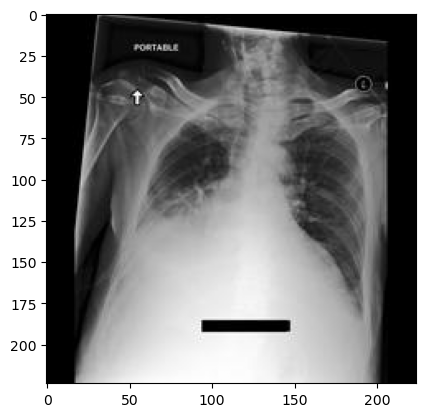

In [196]:
for item in train_dl:
    print(item['input_ids'].shape)
    print(item['pixel_values'].shape)
    break
show_data(item)

In [197]:
vision_encoder = CLIPVisionModel.from_pretrained(IMAGE_MODEL)
#config = CLIPConfig.from_pretrained("openai/clip-vit-base-patch16")
#vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16", config=config.vision_config)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.2.mlp.fc1.weight', 'text_model.encoder.layers.10.self_attn.out_proj.bias', 'text_model.encoder.layers.0.self_attn.q_proj.bias', 'text_model.encoder.layers.10.layer_norm1.weight', 'logit_scale', 'text_model.encoder.layers.7.layer_norm1.weight', 'text_model.encoder.layers.11.self_attn.out_proj.bias', 'text_model.encoder.layers.6.layer_norm2.bias', 'text_model.encoder.layers.5.self_attn.out_proj.bias', 'text_model.encoder.layers.1.mlp.fc1.weight', 'text_model.encoder.layers.5.mlp.fc2.weight', 'text_model.encoder.layers.11.mlp.fc2.weight', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.encoder.layers.5.self_attn.out_proj.weight', 'text_model.encoder.layers.11.layer_norm1.bias', 'text_model.encoder.layers.6.self_attn.k_proj.weight', 'text_model.encoder.layers.3.mlp.fc1.bias', 'text_model.encoder.layers.3.self_attn.out_proj.bias', 'text_mo

In [198]:
text_encoder = CLIPTextModel.from_pretrained(TEXT_MODEL)
#text_encoder = BertModel.from_pretrained("bert-base-uncased")

You are using a model of type bert to instantiate a model of type clip_text_model. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing CLIPTextModel: ['bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.output.dense.weight', 'bert.encoder.layer.5.intermediate.dense.bias', 'bert.encoder.layer.1.attention.self.query.bias', 'bert.encoder.layer.10.output.LayerNorm.weight', 'bert.encoder.layer.10.intermediate.dense.weight', 'bert.encoder.layer.1.attention.self.key.bias', 'bert.encoder.layer.11.attention.self.key.weight', 'bert.encoder.layer.6.attention.self.key.bias', 'bert.encoder.layer.6.intermediate.dense.bias', 'bert.encoder.layer.4.attention.self.query.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.4.intermediate.dense.weight', 'bert.encoder.lay

In [199]:
def clip_wrapper_creator():
    """create a dummy CLIPModel to wrap text and vision encoders in order to use CLIPTrainer"""
    config = {'num_hidden_layers': 0,
              'max_position_embeddings': 0,
              'vocab_size': 0,
              'hidden_size': 1,
              'patch_size': 1,
              }

    #DUMMY_CONFIG = CLIPConfig(text_config_dict=config,vision_config_dict=config)
    DUMMY_CONFIG = CLIPConfig(
        text_config_dict = config,
        vision_config_dict = config
    )

    clip = CLIPModel(config=DUMMY_CONFIG)

    # convert projectors to Identity
    clip.text_projection = nn.Identity()
    clip.visual_projection = nn.Identity()

    return clip


In [200]:
#text_encoder = AutoModel.from_pretrained(TEXT_MODEL)
#text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')

clip = clip_wrapper_creator()
clip.text_model = text_encoder
clip.vision_model = vision_encoder

In [201]:
text_encoder.config.hidden_size

768

In [202]:
vision_encoder.config.hidden_size

768

In [203]:
assert text_encoder.config.hidden_size == vision_encoder.config.hidden_size

In [204]:
if __name__ == '__main__':
    out = clip(input_ids=item['input_ids'],
               attention_mask=item['attention_mask'],
               pixel_values=item['pixel_values'],
               return_loss=True)

    print('text and image embeddings: ',
          out.text_embeds.shape, out.image_embeds.shape)
    print('loss: ', out.loss)
    del out, item

text and image embeddings:  torch.Size([8, 768]) torch.Size([8, 768])
loss:  tensor(2.0957, grad_fn=<DivBackward0>)


## Trainer: train using huggingface trainer
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/train.py

In [205]:
from clip_classes import CLIPTrainer
from transformers.integrations import TensorBoardCallback

In [844]:
def train_model():
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    helper.clear_gpu()
    args.dataloader_num_workers = helper.optimal_workers()
    trainer = CLIPTrainer(clip, args,
                          train_dataset=train_ds,
                          eval_dataset=test_ds,
                          callbacks = [TensorBoardCallback]
                         )

    trainer.train()

train_model()

    # save pretrained models
    # clip.text_model.save_pretrained('radCLIP')
    # tokenizer.save_pretrained('radCLIP')
    # clip.vision_model.save_pretrained('radCLIP')
    # vision_preprocessor.save_pretrained('radCLIP')

/home/andrew/miniconda3/envs/CLIP_demo/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 71866
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 2
  Total optimization steps = 44920
  Number of trainable parameters = 195174145


Step,Training Loss,Validation Loss
100,2.087900,2.087095
200,2.090700,2.077709
300,2.075000,2.072177
400,2.043700,2.058522
500,2.025000,2.040862
600,2.047000,2.018112
700,2.012300,2.007341
800,1.927700,1.971622
900,1.984000,1.963677
1000,1.947900,1.951097


***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evaluation *****
  Num examples = 3783
  Batch size = 8
***** Running Evalua

In [ ]:
    # save pretrained models
    clip.text_model.save_pretrained('radCLIP4')
    tokenizer.save_pretrained('radCLIP4')
    clip.vision_model.save_pretrained('radCLIP4')
    vision_preprocessor.save_pretrained('radCLI4')

# Demo

## Utils: demo utils
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/application/utils.py

In [96]:
class VisionDataset(Dataset):
    preprocess = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ])

    def __init__(self, image_paths: list):
        self.image_paths = image_paths

    def __getitem__(self, idx):
        return self.preprocess(Image.open(self.image_paths[idx]).convert('RGB'))

    def __len__(self):
        return len(self.image_paths)


class TextDataset(Dataset):
    def __init__(self, text: list, tokenizer, max_len):
        self.len = len(text)
        self.tokens = tokenizer(text, padding='max_length',
                                max_length=max_len, truncation=True)

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask}

    def __len__(self):
        return self.len

## CLIPDemo
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/application/main.py

In [97]:
import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import default_data_collator


class CLIPDemo:
    def __init__(self, vision_encoder, text_encoder, tokenizer,
                 batch_size: int = 32, max_len: int = 32, device='cuda'):
        """ Initializes CLIPDemo
            it has the following functionalities:
                image_search: Search images based on text query
                zero_shot: Zero shot image classification
                analogy: Analogies with embedding space arithmetic.

            Args:
            vision_encoder: Fine-tuned vision encoder
            text_encoder: Fine-tuned text encoder
            tokenizer: Transformers tokenizer
            device (torch.device): Running device
            batch_size (int): Size of mini-batches used to embeddings
            max_length (int): Tokenizer max length

            Example:
            >>> demo = CLIPDemo(vision_encoder, text_encoder, tokenizer)
            >>> demo.compute_image_embeddings(test_df.image.to_list())
            >>> demo.image_search('یک مرد و یک زن')
            >>> demo.zero_shot('./workers.jpg')
            >>> demo.anology('./sunset.jpg', additional_text='دریا')
        """
        self.vision_encoder = vision_encoder.eval().to(device)
        self.text_encoder = text_encoder.eval().to(device)
        self.batch_size = batch_size
        self.device = device
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_embeddings_ = None
        self.image_embeddings_ = None
        

    def compute_image_embeddings(self, image_paths: list):
        self.image_paths = image_paths
        datalodear = DataLoader(VisionDataset(
            image_paths=image_paths), batch_size=self.batch_size)
        embeddings = []
        with torch.no_grad():
            for images in tqdm(datalodear, desc='computing image embeddings'):
                image_embedding = self.vision_encoder(
                    pixel_values=images.to(self.device)).pooler_output
                embeddings.append(image_embedding)
        self.image_embeddings_ =  torch.cat(embeddings)

    def compute_text_embeddings(self, text: list):
        self.text = text
        dataloader = DataLoader(TextDataset(text=text, tokenizer=self.tokenizer, max_len=self.max_len),
                                batch_size=self.batch_size, collate_fn=default_data_collator)
        embeddings = []
        with torch.no_grad():
            for tokens in tqdm(dataloader, desc='computing text embeddings'):
                image_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                                    attention_mask=tokens["attention_mask"].to(self.device)).pooler_output
                embeddings.append(image_embedding)
        self.text_embeddings_ = torch.cat(embeddings)

    def text_query_embedding(self, query: str = ''):
        tokens = self.tokenizer(query, return_tensors='pt')
        with torch.no_grad():
            text_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                               attention_mask=tokens["attention_mask"].to(self.device)).pooler_output
        return text_embedding

    def image_query_embedding(self, image):
        image = VisionDataset.preprocess(image).unsqueeze(0)
        with torch.no_grad():
            image_embedding = self.vision_encoder(
                image.to(self.device)).pooler_output
        return image_embedding

    def most_similars(self, embeddings_1, embeddings_2):
        values, indices = torch.cosine_similarity(
            embeddings_1, embeddings_2).sort(descending=True)
        return values.cpu(), indices.cpu()

    def zero_shot(self, image_path: str):
        """ Zero shot image classification with label list 
            Args:
                image_path (str): target image path that is going to be classified
                class_list (list[str]): list of candidate classes 
        """
        image = Image.open(image_path)
        image_embedding = self.image_query_embedding(image)
        values, indices = self.most_similars(image_embedding, self.text_embeddings_)
        for i, sim in zip(indices, torch.softmax(values, dim=0)):
            print(
                f'label: {self.text[i]} | {round(float(sim), 3)}')
        plt.imshow(image)
        plt.axis('off')

    def image_search(self, query: str, top_k=25):
        """ Search images based on text query
            Args:
                query (str): text query 
                image_paths (list[str]): a bunch of image paths
                top_k (int): number of relevant images 
        """
        query_embedding = self.text_query_embedding(query=query)
        _, indices = self.most_similars(self.image_embeddings_, query_embedding)

        matches = np.array(self.image_paths)[indices][:top_k]
        _, axes = plt.subplots(2, int(top_k/2), figsize=(15, 5))
        for match, ax in zip(matches, axes.flatten()):
            ax.imshow(Image.open(match).resize((224, 224)))
            ax.axis("off")
        plt.show()

    def analogy(self, input_image_path: str, additional_text: str = '', input_include=True):
        """ Analogies with embedding space arithmetic.
            Args:
                input_image_path (str): The path to original image 
                image_paths (list[str]): A database of images
        """
        base_image = Image.open(input_image_path)
        image_embedding = self.image_query_embedding(base_image)
        additional_embedding = self.text_query_embedding(query=additional_text)
        new_image_embedding = image_embedding + additional_embedding
        _, indices = self.most_similars(
            self.image_embeddings_, new_image_embedding)

        new_image = Image.open(self.image_paths[indices[1 if input_include else 0]])
        _, ax = plt.subplots(1, 2, dpi=100)
        ax[0].imshow(base_image.resize((250, 250)))
        ax[0].set_title('original image')
        ax[0].axis('off')
        ax[1].imshow(new_image.resize((250, 250)))
        ax[1].set_title('new image')
        ax[1].axis('off')

In [100]:
search = CLIPDemo(vision_encoder, text_encoder, tokenizer)
search.compute_image_embeddings(test_df.image.to_list())
search.compute_text_embeddings(['alveolar', 'pulmonary', 'edema', 'cardiomegaly', 'device'])

computing text embeddings: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 103.67it/s]


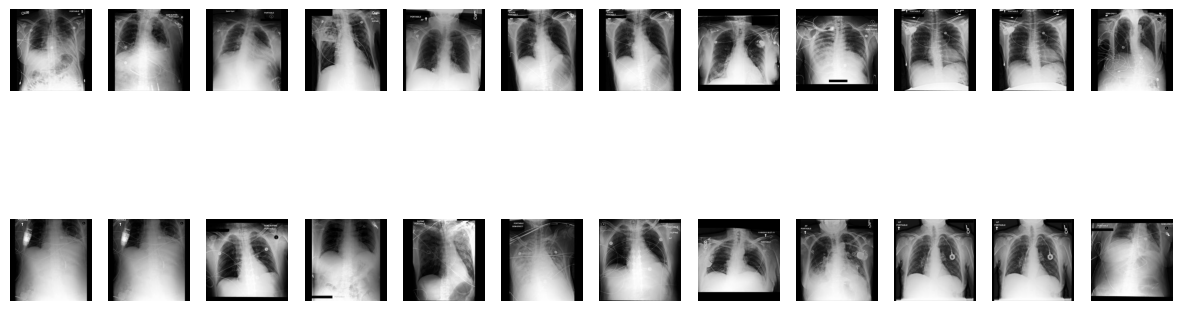

In [101]:
search.image_search('device')

In [108]:
test_df

,caption,image
81561,there is cephalization of vasculature with mil...,/media/andrew/HD-GDU3/498/train/train_resized/...
292345,small left pleural effusion is new.,/media/andrew/HD-GDU3/498/train/train_resized/...
312006,low lung volumes are noted at the current exam.,/media/andrew/HD-GDU3/498/train/train_resized/...
107058,no larger pleural effusions.,/media/andrew/HD-GDU3/498/train/train_resized/...
300852,lungs are clear without focal consolidation.,/media/andrew/HD-GDU3/498/train/train_resized/...
...,...,...
74110,the pulmonary vasculature is normal.,/media/andrew/HD-GDU3/498/train/train_resized/...
136950,no ptx detected.,/media/andrew/HD-GDU3/498/train/train_resized/...
116647,bibasal areas of atelectasis are unchanged.,/media/andrew/HD-GDU3/498/train/train_resized/...
57054,ett terminates appropriately m above carina.,/media/andrew/HD-GDU3/498/train/train_resized/...


In [109]:
test_df["caption"][81561]

'there is cephalization of vasculature with mild cardiomegaly and likely small left pleural effusion with compressive atelectasis.'

label: cardiomegaly | 0.217
label: edema | 0.216
label: pulmonary | 0.208
label: alveolar | 0.18
label: device | 0.179


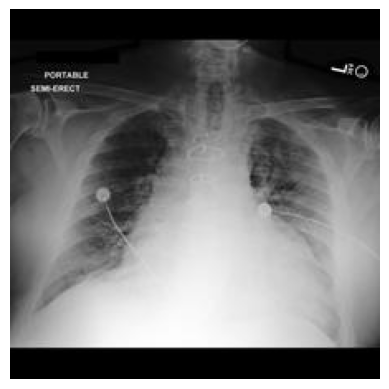

In [110]:
search.zero_shot(f'{test_df["image"][81561]}')

In [106]:
loc = test_df['image'][254]

KeyError: 254

In [ ]:
search.analogy(f'{test["image"][100]}')

## Old Code

In [ ]:
folder = "/media/andrew/HD-GDU3/498/train/"
dataset = "preprocess_metadata_train.csv"
#dataset = "train.csv"
location = folder + dataset

In [ ]:
imageset = pd.read_csv(location)
imageset.head()

In [384]:
#os.path.split(imageset['resized_img_path'][0])[1]
os.path.split(imageset['image'][0])[1]

'ff0ef993-08b09d98-34d71241-01bb236a-6e71ef75.jpg'

In [390]:
os.path.split(imageset['resized_img_path'][1])[1]

'19869118_56152811_54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7.jpg'

In [343]:
folder

'/media/andrew/HD-GDU3/498/train/'

In [354]:
combine_texts(268, db=reports, as_sentences=False)

'comparison to . the patient has been extubated and the nasogastric tube was removed. moderate cardiomegaly persists. the pacemaker is in stable position. also stable is the left-sided swan-ganz catheter. no pulmonary edema, minimal atelectasis at the right lung basis is stable.'

In [360]:
reports.loc[reports['study_id'] == 57540554].index[0]

76059

In [361]:
combine_texts(reports.loc[reports['study_id'] == 57540554].index[0], db=reports, as_sentences=False)

'the cardiomediastinal and hilar contours are within normal limits. the lungs are well expanded and clear. there is no large pleural effusion, pneumothorax or focal consolidation concerning for pneumonia. there is no evidence of free air. no acute cardiopulmonary process. no evidence of free air.'

In [365]:
imageset

,dicom_id,subject_id,study_id,orig_img_path,orig_img_height,orig_img_width,crop_img_path,crop_img_height,crop_img_width,padded_img_path,padding_delta_height,padding_delta_width,padded_img_height,padded_img_width,resized_img_path,resized_img_height,resized_img_width
0,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
1,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
2,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
3,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
4,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57579,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
57580,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
57581,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224
57582,54d5a69b-3e80e7ce-5d561bc1-ebe0e717-fb50c1b7,19869118,56152811,/Volumes/PRO-G40/msds498/files/p19/p19869118/s...,3050,2539,/Volumes/PRO-G40/msds498/output/cropped/198691...,2537,3047,/Volumes/PRO-G40/msds498/output/padded/1986911...,510,0,3047,3047,/Volumes/PRO-G40/msds498/output/resized/198691...,224,224


In [13]:
for item in range(0, len(datasat_nest.sentences)):
    for child in range(0, len(datasat_nest.sentences[item])):
        record = create_record(
            location = location, 
            caption = str(datasat_nest.sentences[item][child]['raw']).lower(),
            image = str(datasat_nest.sentences[item][child]['imgid']+1)+'.jpeg'
        )
        satnet = pd.concat([satnet, record],ignore_index=True)
#datasat_nest.sentences[1][1]['raw']

In [6]:
with open(location, 'r') as f:
    data = json.loads(f.read())
datasat_nest = pd.json_normalize(data, record_path=['images'])

In [7]:
datasat_nest.sentences[0]

[{'tokens': ['There', 'is', 'a', 'piece', 'of', 'formland'],
  'raw': 'There is a piece of farmland .',
  'imgid': 0,
  'sentid': 0},
 {'tokens': ['There', 'is', 'a', 'piece', 'of', 'cropland'],
  'raw': 'There is a piece of cropland .',
  'imgid': 0,
  'sentid': 1},
 {'tokens': ['It', 'is', 'a', 'piece', 'of', 'farmland'],
  'raw': 'It is a piece of farmland .',
  'imgid': 0,
  'sentid': 2},
 {'tokens': ['It', 'is', 'a', 'piece', 'of', 'cropland'],
  'raw': 'It is a piece of cropland .',
  'imgid': 0,
  'sentid': 3},
 {'tokens': ['Here', 'is', 'a', 'piece', 'of', 'farmland'],
  'raw': 'Here is a piece of farmland .',
  'imgid': 0,
  'sentid': 4}]

In [8]:
len(datasat_nest.sentences)

2100

In [9]:
datasat_nest.sentences[572]

[{'tokens': ['This', 'is', 'a', 'chaparral'],
  'raw': 'This is a chaparral .',
  'imgid': 572,
  'sentid': 2860},
 {'tokens': ['Lots', 'of', 'plants', 'scattered', 'on', 'the', 'ground.'],
  'raw': 'Lots of plants scattered on the ground. .',
  'imgid': 572,
  'sentid': 2861},
 {'tokens': ['Lots',
   'of',
   'plants',
   'scattered',
   'in',
   'the',
   'loess',
   'ground.'],
  'raw': 'Lots of plants scattered in the loess ground. .',
  'imgid': 572,
  'sentid': 2862},
 {'tokens': ['There',
   'are',
   'some',
   'grey',
   'plants',
   'scattered',
   'on',
   'the',
   'ground'],
  'raw': 'There are some grey plants scattered on the ground .',
  'imgid': 572,
  'sentid': 2863},
 {'tokens': ['Some',
   'grey',
   'plants',
   'are',
   'scattered',
   'in',
   'the',
   'loess',
   'ground'],
  'raw': 'Some grey plants are scattered in the loess ground .',
  'imgid': 572,
  'sentid': 2864}]

In [10]:
datasat_nest.sentences[1][1]

{'tokens': ['There', 'is', 'a', 'piece', 'of', 'cropland'],
 'raw': 'There is a piece of cropland .',
 'imgid': 1,
 'sentid': 6}

In [13]:
for item in range(0, len(datasat_nest.sentences)):
    for child in range(0, len(datasat_nest.sentences[item])):
        record = create_record(
            location = location, 
            caption = str(datasat_nest.sentences[item][child]['raw']).lower(),
            image = str(datasat_nest.sentences[item][child]['imgid']+1)+'.jpeg'
        )
        satnet = pd.concat([satnet, record],ignore_index=True)
#datasat_nest.sentences[1][1]['raw']

In [14]:
satnet.tail()

,caption,image
10495,four tennis courts on the lawn with a road bes...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10496,four tennis courts are on the lawn and a road ...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10497,there are four tennis courts with a road and s...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10498,there are four tennis courts on the lawn and s...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10499,there are four tennis courts with a road and s...,../CLIP_demo/UCM_captions/imgs/2100.jpeg


In [15]:
satnet.dropna().to_csv('../CLIP_demo/dataset_sat.csv', index=False)